# Trying out segmentation from scratch
## Author : Vincent HERFELD

### I will try to apply the EM algorithm on a GMM of the histogram of intensities of a brain MRI slice. This is a small personnal project.

PNG
(181, 217)
RGBA
L


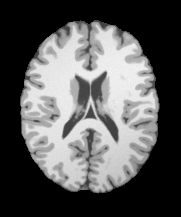

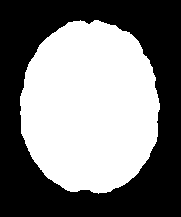

In [270]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Open an image file
img = Image.open('./data/brain.png')  
img_mask = Image.open('./data/brain_mask.png')  
# Print image info
print(img.format)
print(img.size)
print(img.mode)

#convert to grayscale
img = img.convert('L')
img_mask = img_mask.convert('L')
print(img.mode)

#print image
display(img)
display(img_mask)


The mask will help us only consider the foreground in the brain image.

In [251]:
brain_index = np.array(img_mask) > 0 #build 2D array of indexes where the brain is.

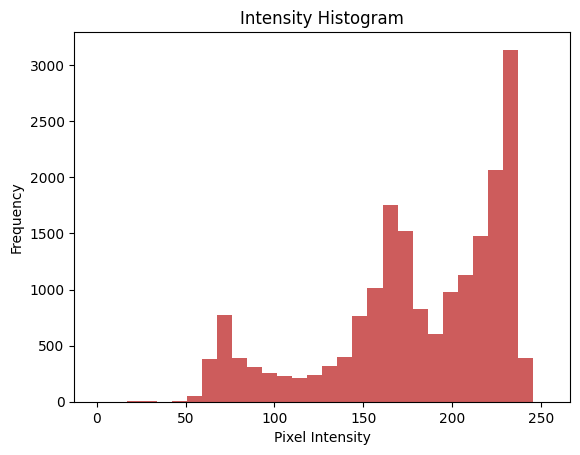

In [256]:
brain = np.array(img)[brain_index]
plt.hist(brain, bins = 30, range=(0, 254), color='indianred')
plt.title('Intensity Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

We must approximate the previous histogram to obtain an approximated density function for the distribution of pixel intensities. This will then be the basis of the EM algorithm we will use to find underlying gaussian densities and thus we will be able to apply appropriate thresholding to segment the image. Since we don't want to consider the background we should crop the image.

In [5]:
def K(x,h):
    return 1/(2*np.pi*h) * np.exp(-0.5 * (x**2 / h**2))

def est_density(x, y, h):
    N = y.shape[0]
    return K(x - y, h).sum() / N

(19221,)


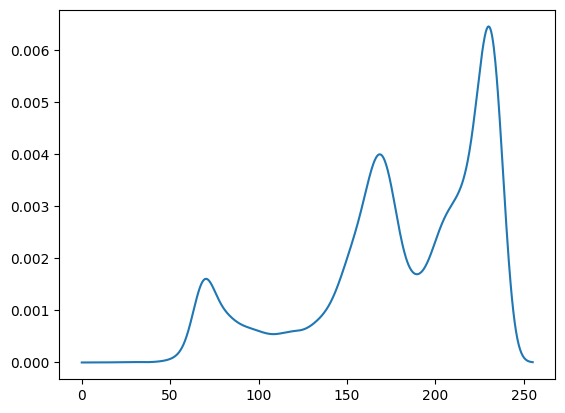

In [14]:
x = np.linspace(0, 255, 1000)

y = brain.flatten()
print(y.shape)

density_plot = []
for xi in x:
    density_plot.append(est_density(xi, y, h=5))

density_plot = np.array(density_plot)   
plt.plot(x, density_plot)

We now have a smooth function to use for the EM algorithm. Looking at the plot we can suppose that there are 3 underlying gaussian distributions each corresponding to the grey matter, white matter and the cerebral fluid.
Let's implement an EM for a Gaussian Mixture model where we introduce latent variables $z$ such that $y_i | z_i \sim \mathcal{N}(\mu_i, \sigma_i^2)$, we also consider $\alpha_j = p(z_i = j)$ so the parameters are $\theta = ((\alpha_i)_i, (\mu_i)_i, (\sigma_i)_i)$. Let's note $\tau_{i,j} = p(z_i = j | y_i, \theta) = \frac{f^t_j(y_i)\alpha^t_j}{\sum_{k=1}^{p} f^t_k(y_i)\alpha^t_k}$ where $f_j$ is the gaussian density associated to the class $j$.

The updates are the updates for a GMM EM algorithm (check my TP2 of CompStats for proof) :

$$
\begin{align*}
    \alpha^{t+1}_{j} &= \frac{1}{n}\sum_{i = 1}^{n} \tau^t_{i,j}\\
     \mu_j^{t+1} &= \frac{\sum_{i=1}^{n}\tau^t_{i,j} y_i}{\sum_{i=1}^{n}\tau^t_{i,j}}\\
    \sigma_j^{2^{t+1}} &= \frac{\sum_{i=1}^{n}(y_i - \mu_j)^2\tau^t_{i,j}}{\sum_{i=1}^{n}\tau^t_{i,j}}
\end{align*}
$$


In [175]:
from scipy.special import logsumexp
from numba import jit

#@jit(nopython=True)
def log_f(x, mu, sigma2):
    return -0.5*(x - mu)**2 / sigma2 - 0.5 * np.log(2*np.pi*sigma2) 

#@jit(nopython=True)
def EM(y, p, N):
    #init
    eps = 1e-16 
    n = y.shape[0]
    alpha = np.empty(p)
    mu = np.empty(p)
    sigma2 = np.empty(p)
    tau = np.empty((n,p))
    log_F = np.empty((n,p))
    
    for j in range(p):
        alpha[j] = (1/p)
        mu[j] = 100 + 10* np.random.normal()
        sigma2[j] = 0.1 + np.abs(np.random.normal())
        
    print(f"alpha : {alpha}, mu : {mu},sigma2 : {sigma2}")
    
    for t in range(N):
        #E step : we compute tau
        for j in range(p):
            log_F[:, j] = np.array([log_f(yi, mu[j], sigma2[j]) for yi in y])
        
        log_alpha_F = np.log(alpha + eps) + log_F
        log_tau = log_F - logsumexp(log_alpha_F, axis=1)[:, np.newaxis]
        tau = np.exp(log_tau)
        
    #M step : we use update rule
        for j in range(p):
            mu[j] = np.sum(y * tau[:,j]) / np.sum(tau[:,j])
            alpha[j] = np.sum(tau[:,j]) / n
            sigma2[j] = np.sum(tau[:, j] * (y - mu[j])**2) / np.sum(tau[:,j])
            
    return alpha, mu, sigma2

In [275]:
alpha, mu, sigma2 = EM(y, 3, 150) #Looking at the histogram we believe that there are 3 main regions that can be identified as the grey matter, white matter, and CS fluid

print(alpha, mu, sigma2)

alpha : [0.33333333 0.33333333 0.33333333], mu : [104.89561793  86.48297643 104.31229323],sigma2 : [0.67541781 1.46978767 1.48121477]
[0.36481382 0.21558241 0.33815897] [173.12568746  89.08105475 225.83624567] [428.83902137 531.08666787  80.70133301]


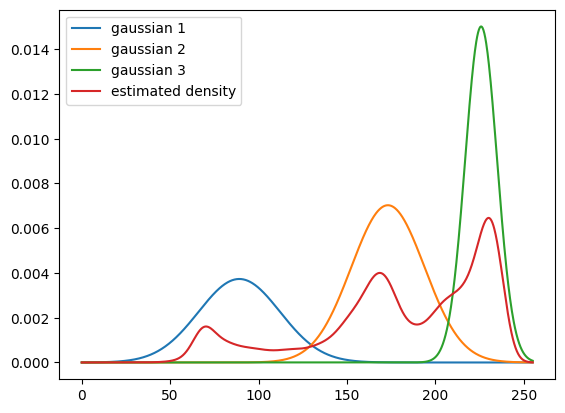

In [276]:
# Get the indices that would sort the first array
sorted_indices = np.argsort(mu)

# Use the sorted indices to sort both arrays
mu = mu[sorted_indices]
sigma2 = sigma2[sorted_indices]
alpha = alpha[sorted_indices]

for j in range(3):
    plt.plot(x, np.exp(log_f(x, mu[j], sigma2[j]))*alpha[j], label=f"gaussian {j+1}")
    
plt.plot(x, density_plot,label="estimated density")
plt.legend()

We have successfully extracted 3 gaussians that describe the histogram. We now need to find the threshold points such that we can segment our image.

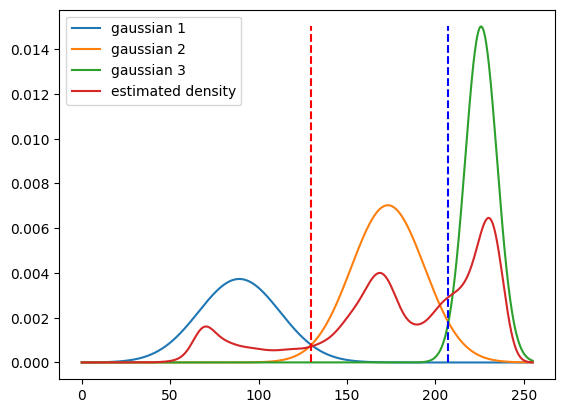

In [277]:
def gaussian_pdf(x, mu = 0, sigma2 = 1):
    return np.exp(log_f(x, mu, sigma2))

def diff(x, a1, mu1, s1, a2, mu2, s2):
    return np.abs(a1*gaussian_pdf(x, mu1, s1) - a2*gaussian_pdf(x, mu2, s2))

thresh_idx1 = np.argmin(diff(x,alpha[0], mu[0], sigma2[0], alpha[1], mu[1], sigma2[1])[int(mu[0])*4:int(mu[1])*4]) + int(mu[0])*4
thresh_idx2 = np.argmin(diff(x,alpha[1], mu[1], sigma2[1], alpha[2], mu[2], sigma2[2])[int(mu[1])*4:int(mu[2])*4]) + int(mu[1])*4

for j in range(3):
    plt.plot(x, np.exp(log_f(x, mu[j], sigma2[j]))*alpha[j], label=f"gaussian {j+1}")
    
plt.plot(x, density_plot,label="estimated density")
plt.vlines(x[thresh_idx1], 0 , np.max(np.exp(log_f(x, mu[2], sigma2[2]))*alpha[2]),linestyles='dashed', color="red")
plt.vlines(x[thresh_idx2], 0 , np.max(np.exp(log_f(x, mu[2], sigma2[2]))*alpha[2]),linestyles='dashed',color="blue")
plt.legend()

We have the threshold indexes now we can split the histogram in 3 regions, and apply a segmentation.

(39277, 3)


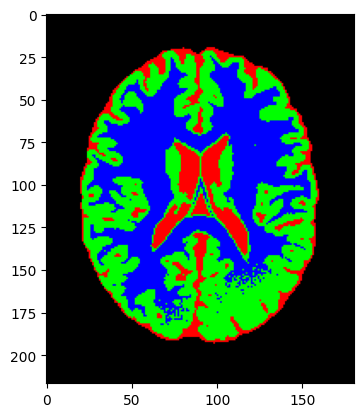

In [278]:
region1_maxval = x[thresh_idx1]
region2_maxval = x[thresh_idx2]


width, height = img.size
img_flat = np.array(img).flatten()
n = img_flat.shape
seg_image = np.stack([np.zeros(n), np.zeros(n),np.zeros(n)]).T
print(seg_image.shape)
for i,yi in enumerate(img_flat):
    if yi < region1_maxval:
        seg_image[i][0] = 1
    elif yi < region2_maxval:
        seg_image[i][1] = 1
    else:
        seg_image[i][2] = 1
        
seg_image = seg_image.reshape((height, width, 3))
seg_image[~brain_index] = [0,0,0] #set background to black
plt.imshow(seg_image)

We have successfully segmented in 3 main regions (white matter - grey matter - cerebrospinal fluid) the brain slice image.